# Applied Data Science Portfolio Assignment: Predicting Protein-Protein Binding Affinity with Automated Machine Learning (AutoML)

Inspired by the Data Science & Society course lectures on AutoML (2020).

Data and scripts available at: https://github.com/Et9797/binding-affinity-prediction

For better rendering view on nbviewer: https://nbviewer.jupyter.org/github/Et9797/binding-affinity-prediction/blob/main/binding-affinity-prediction.ipynb

## Context (Problem/Business Understanding & Data Understanding)

Binding affinity prediction of protein-protein (PP) complexes is a challenging and still unsolved problem in the field of computational structural biology. Accurate prediction of binding affinity is important when designing novel drugs _in silico_. The two most frequently used approaches for predicting binding affinity are: i) running computationally expensive molecular simulations and ii) applying machine learning (ML) on physicochemical descriptors extracted from experimentally solved PP complexes (or models of these complexes) <a href="https://onlinelibrary.wiley.com/doi/10.1002/wcms.1448">[1</a>,<a href="https://academic.oup.com/bib/advance-article-abstract/doi/10.1093/bib/bbaa107/5860693">2]</a>. Here, we focus on the latter. 

A plethora of ML and deep learning (DL) methods have been published on the binding affinity prediction problem. Many recent efforts have concentrated on DL neural network approaches. These have shown to be very robust in accurately predicting binding affinity. However, to my knowledge, Automated Machine Learning (AutoML) <a href="https://en.wikipedia.org/wiki/Automated_machine_learning">[3]</a> has not received as much attention to date, likely because it is still a relatively novel and emerging field. AutoML attempts to automate the entire ML pipeline, from data pre-processing steps such as PCA and feature selection/engineering, to model and hyperparameter selection. Formally, in AutoML literature this is known as the "CASH problem": the Combined Algorithm Selection and Hyperparameter optimization problem. The idea being that by searching a vast model and hyperparameter space, a model could be trained that maximizes predictive performance. 

PRODIGY is a structure-based PP binding affinity predictor that was developed by the HADDOCK team led by prof. Alexandre Bonvin <a href="https://bianca.science.uu.nl/prodigy/method#fig">[4]</a>. A dataset of 81 non-redundant PP complexes was used to train the predictor. The predictor and the dataset it was trained on are both freely accessible from the HADDOCK website <a href="https://bianca.science.uu.nl/prodigy/dataset">[5]</a>. The PRODIGY binding affinity predictions are based on a linear regression model:

\begin{equation}
\mathrm{ΔG_{predicted}} = -0.09459 \ \mathrm{ICs_{charged/charged}} -0.10007 \ \mathrm{ICs_{charged/apolar}} +0.19577 \ \mathrm{ICs_{polar/polar}} -0.22671 \ \mathrm{ICs_{polar/apolar}} +0.18681 \ \mathrm{\%NIS_{apolar}} +0.3810 \ \mathrm{\%NIS_{charged}} -15.9433
\end{equation}

Where $\textrm{ΔG}$ is the Gibbs Free Energy, the predicted binding affinity. The features in the equation are the no. Interatomic Contacts (ICs) and % Non Interacting Surface (NIS) terms. This simple linear model achieves an $R^2$ score of $0.54$ ($r=0.73$), see Figure below.

The goal in this work was to probe whether a model trained using AutoML on the same dataset could outperform the current PRODIGY linear model. For this, we tested two popular AutoML methods TPOT <a href="http://epistasislab.github.io/tpot/">[6]</a> and AutoSklearn <a href="https://automl.github.io/auto-sklearn/master/">[6]</a>, both freely available in the Python programming language. Both AutoML tools were built on top of the widely used Python ML library Scikit-Learn. A 48 hour training time was allocated to both methods. Performance was quantified in terms of $R^2$ and compared to the PRODIGY baseline model $R^2$. The goal was considered successfully reached (success criterium) if at least one AutoML model achieved an $R^2$ that was higher than the baseline PRODIGY model $R^2$, in other words an $R^2 > 0.54$. 

<div>
    <img src="figure.png" width="500"/>
    <p style='text-align:center;'> Source: <a href="https://bianca.science.uu.nl/prodigy/method"> https://bianca.science.uu.nl/prodigy/method</a></p>
</div>

## Data Preparation

In [50]:
import pandas as pd
import numpy as np
import pickle

In [51]:
#Load the dataset that was used to train PRODIGY
df = pd.read_csv("PRODIGY_dataset.csv")
df["PDB"] = df["PDB"].str.replace(".pdb","")
df

,PDB,Interacting_chains,Functional_class,DG,DG_pred,Experimental_method,iRMSD,BSA,ICs_charged-charged,ICs_charged-polar,ICs_charged-apolar,ICs_polar-polar,ICS_polar-apolar,ICs_apolar-apolar,NIS_polar,NIS_apolar,NIS_charged
0,1A2K,C:AB,OG,-9.3,-9.0,ITC,1.11,1603,5,4,20,2,11,25,31.65,41.77,26.58
1,1ACB,E:I,EI,-13.1,-11.9,spectroscopy,1.08,1544,3,2,19,4,19,25,42.72,38.50,18.78
2,1AK4,A:D,OX,-6.4,-7.3,ITC,1.33,1029,0,4,14,1,10,20,27.95,45.41,26.64
3,1AKJ,AB:DE,OX,-5.3,-7.3,SPR,1.14,1995,8,20,7,18,18,2,35.18,35.18,29.64
4,1ATN,A:D,OX,-12.1,-10.9,spectroscopy,3.28,1774,9,8,20,4,15,28,36.32,34.94,28.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2WPT,A:B,NC,-10.7,-11.9,stopped-flow,1.61,1581,8,14,12,2,28,10,23.13,27.21,49.66
77,3BZD,A:B,OX,-9.6,-9.4,ITC,1.08,1312,4,7,6,7,15,12,41.04,29.48,29.48
78,3CPH,G:A,OG,-8.8,-9.3,ITC,2.12,1685,6,7,14,2,15,19,28.77,35.73,35.50
79,3SGB,E:I,EI,-14.5,-13.1,spectroscopy,0.36,1268,3,5,15,2,20,20,49.42,36.05,14.53


The next step was to make the dataset ready for training with the AutoML packages. Luckily, the data was not messy since it was cleaned beforehand by the HADDOCK group. The _PDB_, _Interacting chain_, _iRMSD_, _Functional_class_, _Experimental_method_ and _DG_pred_ (predictions by PRODIGY) columns were removed such that the features used for training matched those used for training the PRODIGY model. This way the regressors produced by TPOT and AutoSklearn will be comparable to PRODIGY. An inherent flaw when assesing model performance with $R^2$ is that $R^2$ will almost always tend to increase when including more variables, regardless if the variable is a good predictor or not. The only additional variable we included in training was the BSA (buried surface area).

In [52]:
df_BA = df.drop(["PDB", "Interacting_chains", "Functional_class", "DG_pred", "Experimental_method", "iRMSD"], axis=1)

In [53]:
df_BA.rename({"DG": "dG"}, axis=1, inplace=True)

In [54]:
df_BA

,dG,BSA,ICs_charged-charged,ICs_charged-polar,ICs_charged-apolar,ICs_polar-polar,ICS_polar-apolar,ICs_apolar-apolar,NIS_polar,NIS_apolar,NIS_charged
0,-9.3,1603,5,4,20,2,11,25,31.65,41.77,26.58
1,-13.1,1544,3,2,19,4,19,25,42.72,38.50,18.78
2,-6.4,1029,0,4,14,1,10,20,27.95,45.41,26.64
3,-5.3,1995,8,20,7,18,18,2,35.18,35.18,29.64
4,-12.1,1774,9,8,20,4,15,28,36.32,34.94,28.74
...,...,...,...,...,...,...,...,...,...,...,...
76,-10.7,1581,8,14,12,2,28,10,23.13,27.21,49.66
77,-9.6,1312,4,7,6,7,15,12,41.04,29.48,29.48
78,-8.8,1685,6,7,14,2,15,19,28.77,35.73,35.50
79,-14.5,1268,3,5,15,2,20,20,49.42,36.05,14.53


In [55]:
X = df_BA.iloc[:,1:].to_numpy()
y = df_BA.iloc[:,0].to_numpy()

In [68]:
_file = open('data_BA.pkl', 'wb')
pickle.dump((X, y), _file)
_file.close()

## Modeling
For convenience TPOT and AutoSklearn were run from separate Python scripts outside this notebook. Default settings were used except for these changes:

    * A maximum of 48 hours of training time was allocated to each method.
    * 4 fold cross-validation (also used for validating PRODIGY).
    * The scoring metric to minimize: mean squared error.
    * The no. of trees hyperparameter was set to [10, 50, 100, 200, 300, 400, 500] for all tree-based regressors in TPOT. 
      AutoSklearn standard considers more than just the default 100 trees used by Scikit-Learn. 
    
The best AutoML pipeline resulting from each method after 48 hours of training is imported below:

In [56]:
#autosklearn model
_model = open("Autoskl_bestmodel.pkl", "rb")
regressor_autoskl = pickle.load(_model)
_model.close()

In [57]:
#tpot model
_model = open("Tpot_bestmodel.pkl", "rb")
regressor_tpot = pickle.load(_model)
_model.close()

## Results

In [58]:
from sklearn.metrics import r2_score
from plotnine import *

Binding affinity predictions from each AutoML model are stored in the dataframe below, alongside the true binding affinities for each PP complex (dG column).

In [59]:
y_pred_tpot = regressor_tpot.predict(X)
y_pred_autoskl = regressor_autoskl.predict(X)

df_pred_BA = pd.DataFrame({'dG': df["DG"], 
                           'PRODIGY': df["DG_pred"],
                           'TPOT': y_pred_tpot.round(1),
                           'AutoSklearn': y_pred_autoskl.round(1)
                          }
                         )
df_pred_BA

,dG,PRODIGY,TPOT,AutoSklearn
0,-9.3,-9.0,-8.6,-9.6
1,-13.1,-11.9,-11.6,-11.9
2,-6.4,-7.3,-7.0,-9.1
3,-5.3,-7.3,-7.1,-9.3
4,-12.1,-10.9,-11.2,-11.0
...,...,...,...,...
76,-10.7,-11.9,-10.6,-9.9
77,-9.6,-9.4,-10.2,-9.6
78,-8.8,-9.3,-9.0,-9.4
79,-14.5,-13.1,-13.5,-13.3


Let us now compute the $R^2$ for the TPOT and AutoSklearn regressors based on these predictions:

In [60]:
print("R^2 PRODIGY (baseline):", round(r2_score(y, df["DG_pred"]), 2))
print("R^2 TPOT:", round(r2_score(y, y_pred_tpot), 2))
print("R^2 AutoSklearn:", round(r2_score(y, y_pred_autoskl), 2))

R^2 PRODIGY (baseline): 0.54
R^2 TPOT: 0.54
R^2 AutoSklearn: 0.45


The best pipelines resulting from both AutoML methods do not outperform the simple linear model used by PRODIGY after 48 hours of training. On the contrary, the AutoSklearn model performs substantially worse compared to PRODIGY ($R^2$=0.45 vs 0.54). 

In the allocated 48 hour time window roughly ~400.000 pipelines were evaluated by TPOT. Several pipelines produced by TPOT had higher $R^2$ than the final best pipeline. A few of the pipelines we tested during the training for example had $R^2$s ranging between 0.60-0.65. However, these pipelines turned out to have higher CV-scores (higher MSE*) on test folds compared to the best pipeline, indicating that these pipelines were most likely overfit to the training data.

\**a lower MSE on the test fold indicates better model performance*

Let us visualize the predicted vs the experimentally determined binding affinities for each method:

In [61]:
#Transform data to long format
pred_BA_long = pd.melt(df_pred_BA, id_vars=['dG'], var_name='Model', value_name='PredBindingAffinity')
pred_BA_long['dG'] = pred_BA_long['dG'].apply(lambda x: abs(x)) #take absolute values for convenience when plotting
pred_BA_long['PredBindingAffinity'] = pred_BA_long['PredBindingAffinity'].apply(lambda x: abs(x))
pred_BA_long['Model'] = pred_BA_long['Model'].astype('category')
pred_BA_long['Model'] = pred_BA_long['Model'].cat.reorder_categories(['PRODIGY', 'TPOT', 'AutoSklearn'])
pred_BA_long

,dG,Model,PredBindingAffinity
0,9.3,PRODIGY,9.0
1,13.1,PRODIGY,11.9
2,6.4,PRODIGY,7.3
3,5.3,PRODIGY,7.3
4,12.1,PRODIGY,10.9
...,...,...,...
238,10.7,AutoSklearn,9.9
239,9.6,AutoSklearn,9.6
240,8.8,AutoSklearn,9.4
241,14.5,AutoSklearn,13.3


In [62]:
r2 = pd.DataFrame({'Model': pd.Series(['PRODIGY', 'TPOT', 'AutoSklearn'], dtype='category'),
                   'R^2':(f'R^2 = {round(r2_score(y, df["DG_pred"]), 2)}', 
                          f'R^2 = {round(r2_score(y, y_pred_tpot), 2)}', 
                          f'R^2 = {round(r2_score(y, y_pred_autoskl), 2)}'
                         )
                  }
                 )
r2

,Model,R^2
0,PRODIGY,R^2 = 0.54
1,TPOT,R^2 = 0.54
2,AutoSklearn,R^2 = 0.45


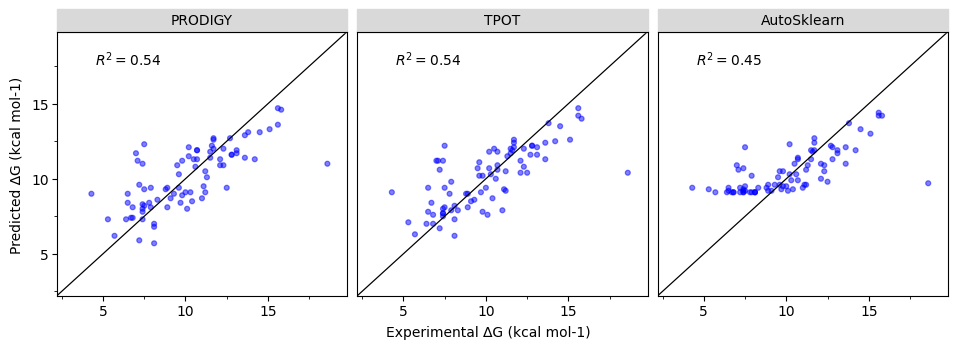

<ggplot: (8732669994907)>

In [63]:
(
    ggplot(pred_BA_long, aes(x='dG', y='PredBindingAffinity')) +
        geom_point(alpha=0.5, colour='blue') +
        xlab("Experimental ∆G (kcal mol-1)") +
        ylab("Predicted ∆G (kcal mol-1)") +
        ylim(3, 19) +
        xlim(3, 19) +
        facet_wrap('Model') +
        geom_abline(slope=1, intercept=0) +
        geom_text(data=r2, mapping=aes(label='R^2'), x=6.5, y=18, parse=True, size=10) +
        theme_matplotlib() +
        theme(figure_size = (11.5, 3.5)) 
    
)

The line shown is the x=y line, i.e. if predictions were to be perfect. TPOT performed comparably to the PRODIGY model. However, the AutoSklearn regressor performed significantly worse. Apparently it never predicted binding affinities of $ \mathrm{∆G}> \approx-9$, which explains why it performed worse than the TPOT regressor. The reason for this is unclear however. A possible explanation may be the short training time that was allocated. Insufficient time for the algorithm to explore potentially better pipelines may have curbed discovery of better pipelines.

## Evaluation and Discussion

No improvement in binding affinity predictions was accomplished using the AutoML methods TPOT and AutoSklearn. With respect to the formulated goal, we can conclude that our initially stated success criterium of $R^2 > 0.54$ was not satisfied. Both the TPOT and AutoSklearn regressors did not yield better binding affinity predictions compared to baseline PRODIGY regressor. On the contrary, the AutoSklearn regressor was substantially worse than the baseline regressor. Although higher performance could potentially be achieved with a longer training time, this unequivocally comes at the cost of the interpretability of the models generated. Most pipelines resulting from AutoML are a complete blackbox. Therefore, only if the performance of such a model were to be significantly better than the currently employed linear model would its implementation in practice be justified.

Overfitting is a concern in AutoML methods, however we do not suspect any case of overfitting here. If models were suspected of overfitting, one could opt to retrain using leave one out cross-validation (LOOCV), which is generally the recommended approach on smaller datasets like the one used here. However, this approach also has inherent disadvantages, such as an increase in computational time and high variance. In addition, since 4-fold CV was used in training the PRODIGY model, it would also make these models trained using LOOCV less comparable.

Practically, it is more often the case that a prediction is sought after for a model of a protein-protein complex without having a prior solved complex available, for instance on a PP model generated with the use of a molecular docking program like HADDOCK. The AutoML regressors trained here can also be used for generating binding affinity predictions on models of a complex generated by HADDOCK. If the removed variables in data preparation were included instead, the predictions would technically only be possible and valid for solved complexes. 

Concrete next steps to take from here would be to retrain the models, allocating a longer time window for training, though there is no guarantee an optimal model will ever result from this that affords better binding affinity predictions. More data should be collected and included in the training of the models. The dataset used here was quite small. It is well-known that models trained on bigger datasets improve the reliability of the predictions made by the model. In addition, future work in the field will undoubtedly lead to discovery of more relevant features that have high explanatory power, leading to models with improved binding affinity predictions. All in all, AutoML is a promising  field, and together with (automated) deep learning interesting applications may emerge within the computational (structural) biology and chemistry fields in the future. However, thorough evaluation is still required before implementation in practice is justified.